In [536]:
import yfinance as yf
import pandas as pd

def create_df_for_multi_companies(
        raw_data_multiindex:pd.MultiIndex, 
        stock_var:str, 
        companies:list[str]):
    
    raw_values = {}
    for company in companies:
        # Transform MultiIndex DF into SingleIndex DF for each company with all prices (Open, Close... Adj. Close)
        raw_data_by_company = raw_data_multiindex.xs(key=company, level='Ticker', axis=1, drop_level=False)
        # Grab only the Datetime and the desired price (e.g., colums -> [Datetime | Open])
        raw_data_series = raw_data_by_company[(stock_var,company)]
        # Make a dictionary of type {company[x] : [Open Values 0, 1, ... N] ... }
        raw_values[company] = raw_data_series.values
    # Create 'df' Dataframe only with "Datetime" Column
    df = pd.DataFrame({'Datetime':raw_data_series.index})
    # Append all columns with values for each company, resulting in [Datetime | Company_values[x] ...]
    df = df.assign(**raw_values)
    return df

def get_finance_df(
        companies:str|list[str], 
        start_date:str, 
        end_date:str, 
        stock_var:str='Adj Close') -> pd.DataFrame:
    
    try:
        # In case companies is a string, transform into a list of 1 object, like: ['company']
        if not isinstance(companies,list):
            companies:list[str] = [companies]
        
        # Download data using yfinance
        raw_data_multiindex:pd.MultiIndex = yf.download(tickers=companies, start=start_date, end=end_date)

        # Transform the raw data into a suitable DF
        df = create_df_for_multi_companies(raw_data_multiindex, stock_var, companies)

        return df
    
    except:
            Exception("Unexpected error: something wrong occurred while creating the finance DF")


def split_train_test_valid_df(df, horizon_pred=1, seq_length=30, size_train_percent=0.75, size_test_percent=0.2):
    N = len(df)-seq_length-horizon_pred
    Ntrain = int(size_train_percent*N)
    Ntest = int(size_test_percent*N)
    
    df_train = df.loc[0:Ntrain]
    df_test = df.loc[Ntrain+1:Ntrain+Ntest]
    df_valid = df.loc[Ntrain+Ntest+1:]

    Nvalid = len(df_valid)
    if (Nvalid < (seq_length+horizon_pred+1)):
        raise ValueError(f"""At least (seq_length+horizon_pred+1) samples are needed for validation. You have seq_length={seq_length}, horizon_pred={horizon_pred} and Nvalid={Nvalid} samples, with Ntrain={Ntrain}, Ntest={Ntest} and N={N}. Try changing the prediction horizon, the sequence/window length, or increasing the number of samples""")

    return (df_train, df_test, df_valid)

def shift_drop_na_in_xy(df, company_inputs, company_output, horizon_pred):
    new_df = pd.concat([df[company_inputs], df[company_output].rename("target").shift(-horizon_pred)],axis='columns').dropna()
    X = new_df[company_inputs].values
    y = new_df["target"].values
    return X, y

In [537]:
# from feature_engineering import get_finance_df

# Load dataset
# company_inputs = ['PETR4.SA', 'BZ=F', '6L=F']
company_inputs = ['PETR4.SA']
company_output = 'PETR4.SA'
end_date = '2024-10-01' 
start_date = '2020-01-01'
stock_var = 'Adj Close'

horizon_pred = 1
seq_length = 30
batch_size = 30
train_ratio = 0.75
test_ratio = 0.2

units_layer1 = 200
activation_layer1 = 'relu'
dropout_layer1 = 0.2
units_layer2 = None
activation_layer2 = None if units_layer2 is None else 'relu'
dropout_layer2 = None if units_layer2 is None else 0.1
activation_output = 'relu'

optim = 'adam'
loss_fn = 'mse'
n_epochs = 150

df = get_finance_df(company_inputs, start_date, end_date, stock_var)
df = df.fillna(0)

n_inputs = len(company_inputs)

print(df)
print(n_inputs)


[*********************100%***********************]  1 of 1 completed

                      Datetime   PETR4.SA
0    2020-01-02 00:00:00+00:00  10.621440
1    2020-01-03 00:00:00+00:00  10.534945
2    2020-01-06 00:00:00+00:00  10.659495
3    2020-01-07 00:00:00+00:00  10.617979
4    2020-01-08 00:00:00+00:00  10.552242
...                        ...        ...
1178 2024-09-24 00:00:00+00:00  36.779999
1179 2024-09-25 00:00:00+00:00  37.049999
1180 2024-09-26 00:00:00+00:00  36.250000
1181 2024-09-27 00:00:00+00:00  36.110001
1182 2024-09-30 00:00:00+00:00  36.009998

[1183 rows x 2 columns]
1


In [538]:
df_train, df_test, df_valid = split_train_test_valid_df(df=df, 
    horizon_pred=horizon_pred, seq_length=seq_length, 
    size_train_percent=train_ratio, size_test_percent=test_ratio
    )

In [539]:
X_train, y_train = shift_drop_na_in_xy(df_train, company_inputs, company_output, horizon_pred=horizon_pred)
X_test, y_test = shift_drop_na_in_xy(df_test, company_inputs, company_output, horizon_pred=horizon_pred)
X_valid, y_valid = shift_drop_na_in_xy(df_valid, company_inputs, company_output, horizon_pred=horizon_pred)

In [540]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler

# Normalize the Price column
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_y_train = scaler.fit_transform(y_train.reshape(-1, 1))

scaled_X_test = scaler.fit_transform(X_test)
scaled_y_test = scaler.fit_transform(y_test.reshape(-1, 1))

scaled_X_valid = scaler.fit_transform(X_valid)
scaled_y_valid = scaler.fit_transform(y_valid.reshape(-1, 1))

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Initialize generator with multivariable input and single target
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=seq_length, batch_size=batch_size)
generator_test = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=seq_length, batch_size=batch_size)
generator_valid = TimeseriesGenerator(scaled_X_valid, scaled_y_valid, length=seq_length, batch_size=batch_size)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Define the LSTM model

if (units_layer2 is None) or (activation_layer2 is None):
    print("layers = 1")
    model = Sequential([
        LSTM(units=units_layer1, activation=activation_layer1, input_shape=(seq_length, n_inputs)),
        Dropout(rate=dropout_layer1),
        Dense(1, activation=activation_output)
    ])
else:
    print("layers = 2")
    model = Sequential([
        LSTM(units=units_layer1, activation=activation_layer1, input_shape=(seq_length, n_inputs), return_sequences=True),
        Dropout(rate=dropout_layer1),
        LSTM(units=units_layer2, activation=activation_layer2),
        Dropout(rate=dropout_layer2),
        Dense(1, activation=activation_output)
    ])

model.compile(optimizer=optim, loss=loss_fn)

# Train the model
model.fit(generator, epochs=n_epochs, validation_data=generator_test)


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [542]:
X_gen_valid, y_gen_valid = generator_valid[0]
y_pred_scaled = model.predict(X_gen_valid).reshape(-1,)
print(y_pred_scaled)
print(y_gen_valid[1:].reshape(-1,))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
[0.5825784  0.60202354 0.6003721  0.6223932  0.63029724 0.648309
 0.6540382  0.6674966  0.6141926  0.53066623 0.4950533  0.47698808
 0.4705624  0.41392165 0.35457462 0.37435305 0.356459   0.25918525
 0.17351787 0.15778406 0.16137119 0.22455943 0.25845367 0.3393664
 0.38360837 0.45408767 0.53806525 0.6063709  0.6439983  0.6476768 ]
[0.63171803 0.61518089 0.64825516 0.63667871 0.66313852 0.53580213
 0.45477088 0.50438229 0.49611339 0.48949893 0.36381696 0.32578136
 0.45146332 0.35720185 0.17363959 0.16867826 0.27120862 0.26294038
 0.35885498 0.30262911 0.43988752 0.40185192 0.50934297 0.60525887
 0.63171803 0.62179536 0.59698998 0.55895502 0.57820737]


In [543]:
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
y_valid_f = scaler.inverse_transform(y_gen_valid.reshape(-1,1))
print(y_pred.T, y_valid_f.T)

[[37.145702 37.26003  37.25032  37.379795 37.42627  37.532173 37.56586
  37.64499  37.33158  36.840473 36.63108  36.524864 36.487083 36.154057
  35.805115 35.921402 35.816193 35.244255 34.74056  34.64805  34.669144
  35.04067  35.239956 35.715694 35.975822 36.390217 36.883976 37.28559
  37.50683  37.528458]] [[37.09431076 37.43462372 37.3373909  37.53185654 37.46379089 37.61936569
  36.87067032 36.3942337  36.68593216 36.63731384 36.598423   35.85945511
  35.63581848 36.37478638 35.82056046 34.74127579 34.7121048  35.31494904
  35.26633453 35.8302803  35.49969101 36.30672455 36.08308792 36.71509933
  37.27905273 37.43462372 37.37628174 37.23043442 37.00680161 37.11999893]]


In [554]:
from sklearn.metrics import root_mean_squared_error, r2_score

delay = 3

rmse = root_mean_squared_error(y_pred[delay:], y_valid_f[0:-delay])
r2 = r2_score(y_pred[delay:], y_valid_f[0:-delay])

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

RMSE: 0.2979
R² Score: 0.9072


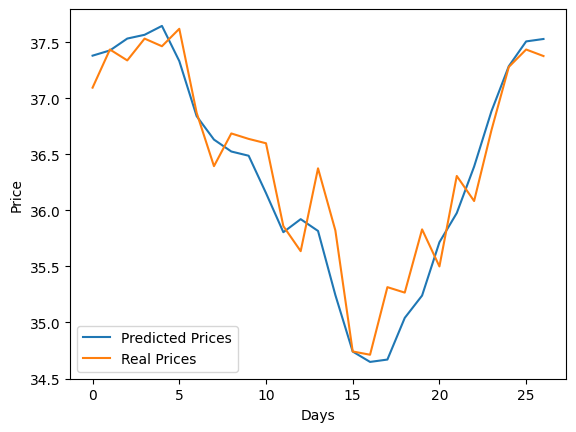

In [555]:
import matplotlib.pyplot as plt

# Plot the predicted prices
plt.plot(y_pred[delay:], label="Predicted Prices")
plt.plot(y_valid_f[0:-delay], label="Real Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [546]:
# import mlflow
# import mlflow.tensorflow

# mlflow.set_tracking_uri(uri="http://127.0.0.1:7777")
# mlflow.set_experiment("LSTM Experiments")

# from sklearn.metrics import root_mean_squared_error, r2_score

# mlflow.tensorflow.autolog()
# with mlflow.start_run():
#     mlflow.tensorflow.log_model(model, "model")

#     # Calculate RMSE and R² score
#     rmse = root_mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     print(f'RMSE: {rmse:.4f}')
#     print(f'R² Score: {r2:.4f}')

#     mlflow.log_metric("RMSE", rmse)
#     mlflow.log_metric("R2-Score", r2)

In [547]:
# # Predict using the trained model
# future_steps = 10  # Number of days to predict
# future_data = data[-n_steps:].reshape(-1, n_steps, 1)
# predicted_prices = []

# for i in range(future_steps):
#     prediction = model.predict(future_data)[0, 0]
#     predicted_prices.append(prediction)
#     future_data = np.roll(future_data, -1, axis=1)
#     future_data[0, -1] = prediction

# # Inverse transform the predicted prices to original scale
# predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

In [548]:
# import matplotlib.pyplot as plt

# # Plot the predicted prices
# plt.plot(predicted_prices, label="Predicted Prices")
# plt.xlabel("Days")
# plt.ylabel("Price")
# plt.legend()
# plt.show()